
Welcome to this tutorial on installing and using the latest CorgiSim simulation tools. In this guide, we'll walk through how to set up and run simulations of an on-axis host star with off-axis companions for observations with the Roman Coronagraph Instrument (CGI).

 This tutorial is intended to help you get started quickly and to provide a clear overview of CorgiSim’s current infrastructure and workflow. It's especially geared toward those interested in contributing to the development and improvement of the code.


# Installation

Since **CorgiSim** is still under active development, we recommend cloning the **main** branch from the repository and installing it in **editable mode**. It's also best to work in a **virtual environment** to avoid conflicts with other packages.

## Step-by-step instructions

1. **Clone the repository:**


```
    git clone -b main https://github.com/roman-corgi/corgisim.git
    cd corgisim
```
2. **Install in editable mode:**

```
    pip install -e .
```

## Required dependencies
Make sure the following packages are installed. Among them, **cgisim**, **roman_preflight** and **proper**
 must be installed manually, as they are not available via PyPI and cannot be installed with `pip`:
- cgisim
- roman_preflight
- PROPER
- synphot




# Run the first simulation


In [2]:
## import packages
from corgisim import scene
from corgisim import instrument
import matplotlib.pyplot as plt
import numpy as np
import proper

#### Step 0: Copying a Prescription File

To get started, you'll need a Roman CGI prescription file in your working folder. The `roman_preflight_proper` package provides a helper function to copy a default prescription file into your current working directory.



In [3]:
#First, import the module:
import roman_preflight_proper
### Then, run the following command to copy the default prescription file 
roman_preflight_proper.copy_here

<function roman_preflight_proper.copy_here.copy_here()>

### Step 1: Define the Astrophysical Scene

Begin by specifying the astrophysical scene you want to simulate. This typically includes:

- A **host star**
- One or more **companions** (e.g., exoplanets or brown dwarfs)
- *(Future feature)* A 2D background scene, such as circumstellar disks — *not yet implemented*

> **Note:** As of now, only point sources (host stars and companions) are supported. 2D scene functionality will be added in future versions.

#### 🔹 Host Star

The following parameters are required for defining the host star:

1. **Spectral type** (e.g., `"G2V"`)
2. **V-band magnitude** (numeric value)
3. **Magnitude type** — currently, only **Vega magnitude** (`"vegamag"`) is supported

#### 🔹 Companions

You may define multiple companions. For each one, specify:

1. **V-band magnitude** brigtness of the companions  
2. **Magnitude type** — currently, only **Vega magnitude** (`"vegamag"`) is supported  
3. **position_x** — X-coordinate of the source position in milliarcseconds (mas), relative to the host star  
4. **position_y** — Y-coordinate of the source position in milliarcseconds (mas), relative to the host star  
5. **Custom spectrum** *(optional)* — A custom spectrum file or array. If not provided, a flat spectrum will be generated based on the V-band magnitude

✅ Make sure to provide values in the expected format so the simulation can interpret the astrophysical inputs correctly.


In [4]:
# --- Host Star Properties ---
Vmag = 8                            # V-band magnitude of the host star
sptype = 'G0V'                      # Spectral type of the host star
host_star_properties = {'Vmag': Vmag,
                        'spectral_type': sptype,
                        'magtype': 'vegamag'}

# --- Companion Properties ---
# Define two companions
mag_companion = [25, 25]           # List of magnitudes for each companion

# Define their positions relative to the host star, in milliarcseconds (mas)
# For reference: 1 λ/D at 550 nm with a 2.3 m telescope is ~49.3 mas
# We're placing them at a separation of 3 λ/D
dx = [3 * 49.3, -3 * 49.3]         # X positions in mas
dy = [3 * 49.3, -3 * 49.3]         # Y positions in mas

# Construct a list of dictionaries for all companion point sources
point_source_info = [
    {
        'Vmag': mag_companion[0],
        'magtype': 'vegamag',
        'position_x': dx[0],
        'position_y': dy[0]
    },
    {
        'Vmag': mag_companion[1],
        'magtype': 'vegamag',
        'position_x': dx[1],
        'position_y': dy[1]
    }
]

# --- Create the Astrophysical Scene ---
# This Scene object combines the host star and companion(s)
base_scene = scene.Scene(host_star_properties, point_source_info)

# --- Access the generated stellar spectrum ---
sp_star = base_scene.stellar_spectrum
# --- Access the generated companion spectrum ---
sp_comp = base_scene.off_axis_source_spectrum 


Adding 2 off-axis sources


Let's plot the stellar spectrum to have a look. Currently, we only have blackbody spectrum, but will add more complated onrs in future.


Text(0, 0.5, 'flux (photons/s/cm^2/A)')

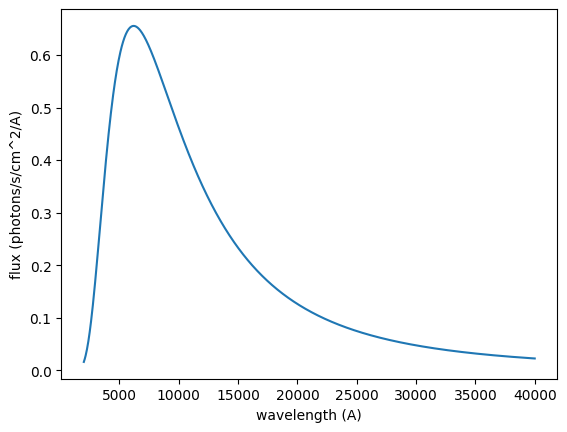

In [5]:
ax=plt.subplot(111)
#sp.plot(ax=ax)
lambd = np.linspace(2000, 40000, 1000)
ax.plot(lambd , sp_star(lambd  ).value,label='corgisim')
ax.set_xlabel('wavelength (A)')
ax.set_ylabel('flux (photons/s/cm^2/A)')

Let's then plot the spectrum of the first companion. Since we didn't provide a custom spectrum, it uses the default flat spectrum automatically generated based on its V-band magnitude.

Text(0, 0.5, 'flux (photons/s/cm^2/A)')

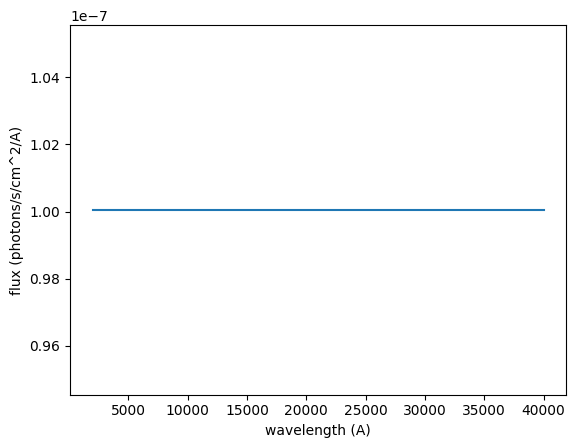

In [6]:
ax=plt.subplot(111)
#sp.plot(ax=ax)
lambd = np.linspace(2000, 40000, 1000)
ax.plot(lambd , sp_comp[0](lambd  ).value,label='corgisim')
ax.set_xlabel('wavelength (A)')
ax.set_ylabel('flux (photons/s/cm^2/A)')

#### Step2: now you need to define the parameters for the telescope and instrument

The simulation mode is inherited from cgisim. In general, there are four supported modes, though currently only excam is implemented.

In [7]:
# Simulation mode (currently only 'excam' is implemented)
# Options include:
#   - 'excam': direct imaging mode (returns intensity image)
#   - 'spec': spectral mode using the "spc-spec" coronagraph
#   - 'lowfs': LOWFS camera, usable with any coronagraph
#   - 'excam_efield': like 'excam', but returns electric field across wavelengths instead of intensity
cgi_mode = 'excam'


Choose the coronagraph type to use in the simulation. As of now, only hlc is implemented.

In [8]:
# Coronagraph type
# Options (availability depends on implementation status):
#   - 'hlc', 'hlc_band1', 'hlc_band2', 'hlc_band3', 'hlc_band4'
#   - 'spc-spec_band2', 'spc-spec_band3'
#   - 'spc-wide_band1', 'spc-wide_band4'
#   - 'spc-mswc_band1', 'spc-mswc_band4'
#   - 'zwfs'
cor_type = 'hlc'


Set the filter for your simulation. corgisim will automatically read the appropriate filter curve, accounting for throughput losses from OTA obscurations, reflections, filters, and CCD quantum efficiency. 

Bandpass filter to use with the chosen coronagraph. Available options depend on the coronagraph type.
For example, if using 'hlc' or 'hlc_band1', valid bandpasses include:'1', '1a', '1b', '1c', '1_all'.  For more details on available bandpasses and how they’re defined, refer to the cgisim documentation: **cgisim_public_v4.0.pdf**

In [9]:
bandpass = '1'

Load a Pre-Saved DM File. Several pre-generated deformable mirror (DM) files are available for different coronagraph types and contrast configurations. 

Available configurations:
- HLC:
    hlc_ni_2e-9, hlc_ni_3e-8, hlc_ni_5e-9

- SPC-Spec:
    spc-spec_ni_1e-9, spc-spec_ni_2e-8, spc-spec_ni_4e-9

- SPC-Wide:
    spc-wide_ni_2e-8, spc-wide_ni_3e-9, spc-wide_ni_5e-9

In [10]:

cases = ['3e-8']       
rootname = 'hlc_ni_' + cases[0]
dm1 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm1_v.fits' )
dm2 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm2_v.fits' )



The `polaxis` parameter is integer to define the axis of polarization aberrations

**Accepted values:**

- `-2`: -45° input polarization, +Y output
- `-1`: -45° input polarization, +X output
- `0`: No polarization (None)
- `1`: +45° input polarization, +X output
- `2`: +45° input polarization, +Y output
- `5`: Mean of ±45° input, +X output
- `6`: Mean of ±45° input, +Y output
- `10`: Mean of all polarization axes


In [11]:
polaxis = 10
# output_dim define the size of the output image
output_dim = 51

### define a dictinatary to pass keywarod to proper
proper_keywords ={'cor_type':cor_type, 'use_errors':2, 'polaxis':polaxis, 'output_dim':output_dim,\
                    'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1, 'use_lyot_stop':1,  'use_field_stop':1 }

##define the corgi.optics class that hold all information about the instrument paramters                    
optics = instrument.CorgiOptics(cgi_mode, bandpass, proper_keywords=proper_keywords, if_quiet=True)

CorgiOptics initialized with proper keywords.


Now let's plot the filter curve 

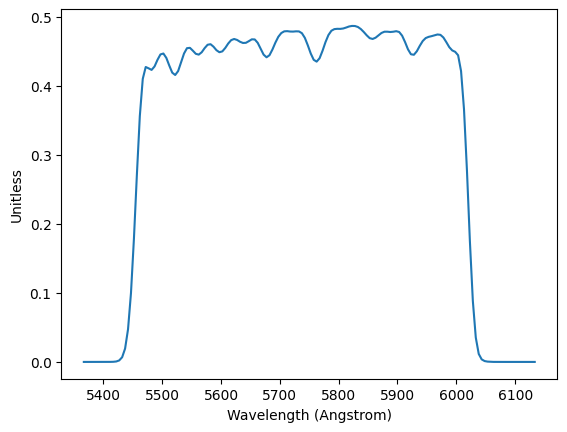

In [12]:
bp = optics.setup_bandpass(cgi_mode, bandpass, 0)
bp.plot()

### Step 3, generate the psf for the on-axis star and inject the companions

In [13]:
sim_scene = optics.get_psf(base_scene)
image_star_corgi = sim_scene.host_star_image.data

Next, you can generate the image of the off-axis point sources and inject it into the PSF image.

In [14]:
sim_scene = optics.inject_point_sources(base_scene,sim_scene)
image_comp_corgi = sim_scene.point_source_image.data 
combined_image_corgi = image_star_corgi + image_comp_corgi

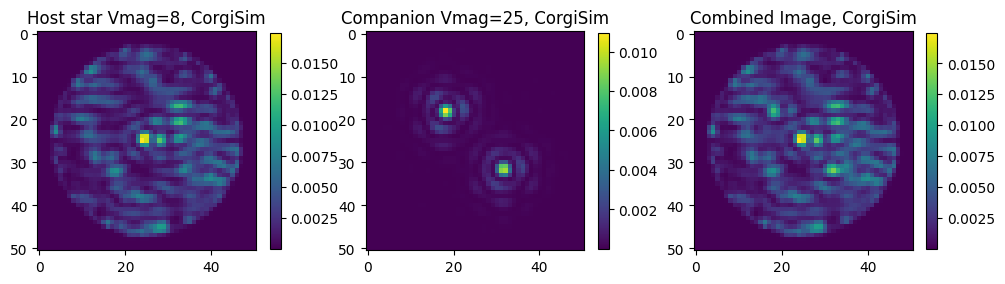

In [15]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(image_star_corgi)
plt.title('Host star Vmag=8, CorgiSim')

co = plt.colorbar(shrink=0.7)
plt.subplot(132)
plt.imshow(image_comp_corgi)
plt.title('Companion Vmag=25, CorgiSim')

co = plt.colorbar(shrink=0.7)

plt.subplot(133)
plt.imshow(combined_image_corgi)
plt.title('Combined Image, CorgiSim')

co = plt.colorbar(shrink=0.7)

### Step 4, simulate the image on detetcor
So far, we've simulated images of a host star with two companions using Roman-CGI. However, we haven't included detector noise yet! In the next step, we'll define a **corgi.Detector** object to add that to the simulation.

In [16]:
### In this example, we'll use the default parameters for the EMCCD detector (recommended), except for the EM gain.
 
gain =100
emccd_keywords ={'em_gain':gain}
detector = instrument.CorgiDetector( emccd_keywords)

#In real observations, exposures are typically broken into a sequence of short frames (e.g., 100s per frame) to reduce the impact of cosmic ray hits.
#However, for simplicity in this example, we'll simulate a single long exposure (10000s) here.
exptime = 10000
sim_scene = detector.generate_detector_image(sim_scene,exptime)
image_tot_corgi_sub= sim_scene.image_on_detector.data

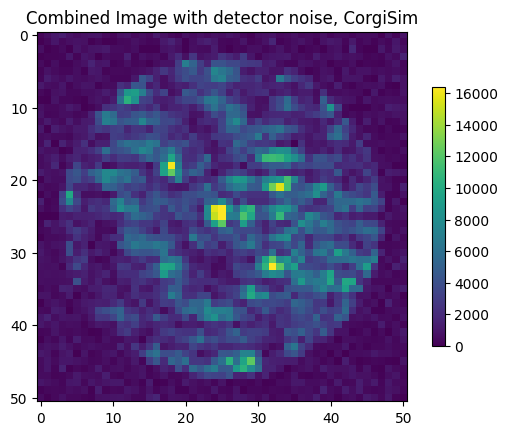

In [17]:
plt.imshow(image_tot_corgi_sub)
plt.title('Combined Image with detector noise, CorgiSim')

co = plt.colorbar(shrink=0.7)

We're not done yet! To complete the simulation, we need to generate a **Level 1 (L1) data product** — a full-frame EMCCD image.

This requires placing the subframe we just simulated onto the full Roman EMCCD frame.  
You can do this by setting the keyword `full_frame=True` in the detector call.

- `loc_x` and `loc_y` specify the center position (in pixels) where the subframe should be placed on the full EMCCD frame.


In [18]:

sim_scene = detector.generate_detector_image(sim_scene,exptime,full_frame=True,loc_x=300, loc_y=300)
image_tot_corgi_full = sim_scene.image_on_detector.data

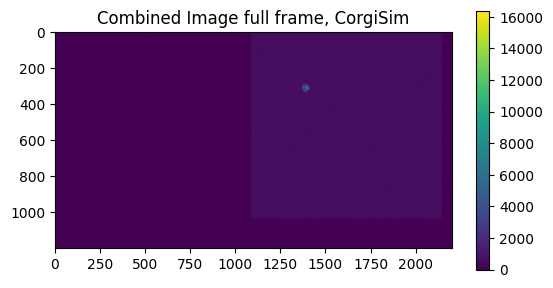

In [19]:
plt.imshow(image_tot_corgi_full)
plt.title('Combined Image full frame, CorgiSim')

co = plt.colorbar(shrink=0.7)